# Init

In [1]:
import math

import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


# EDA

Let's check the number of movies and reviews over years.

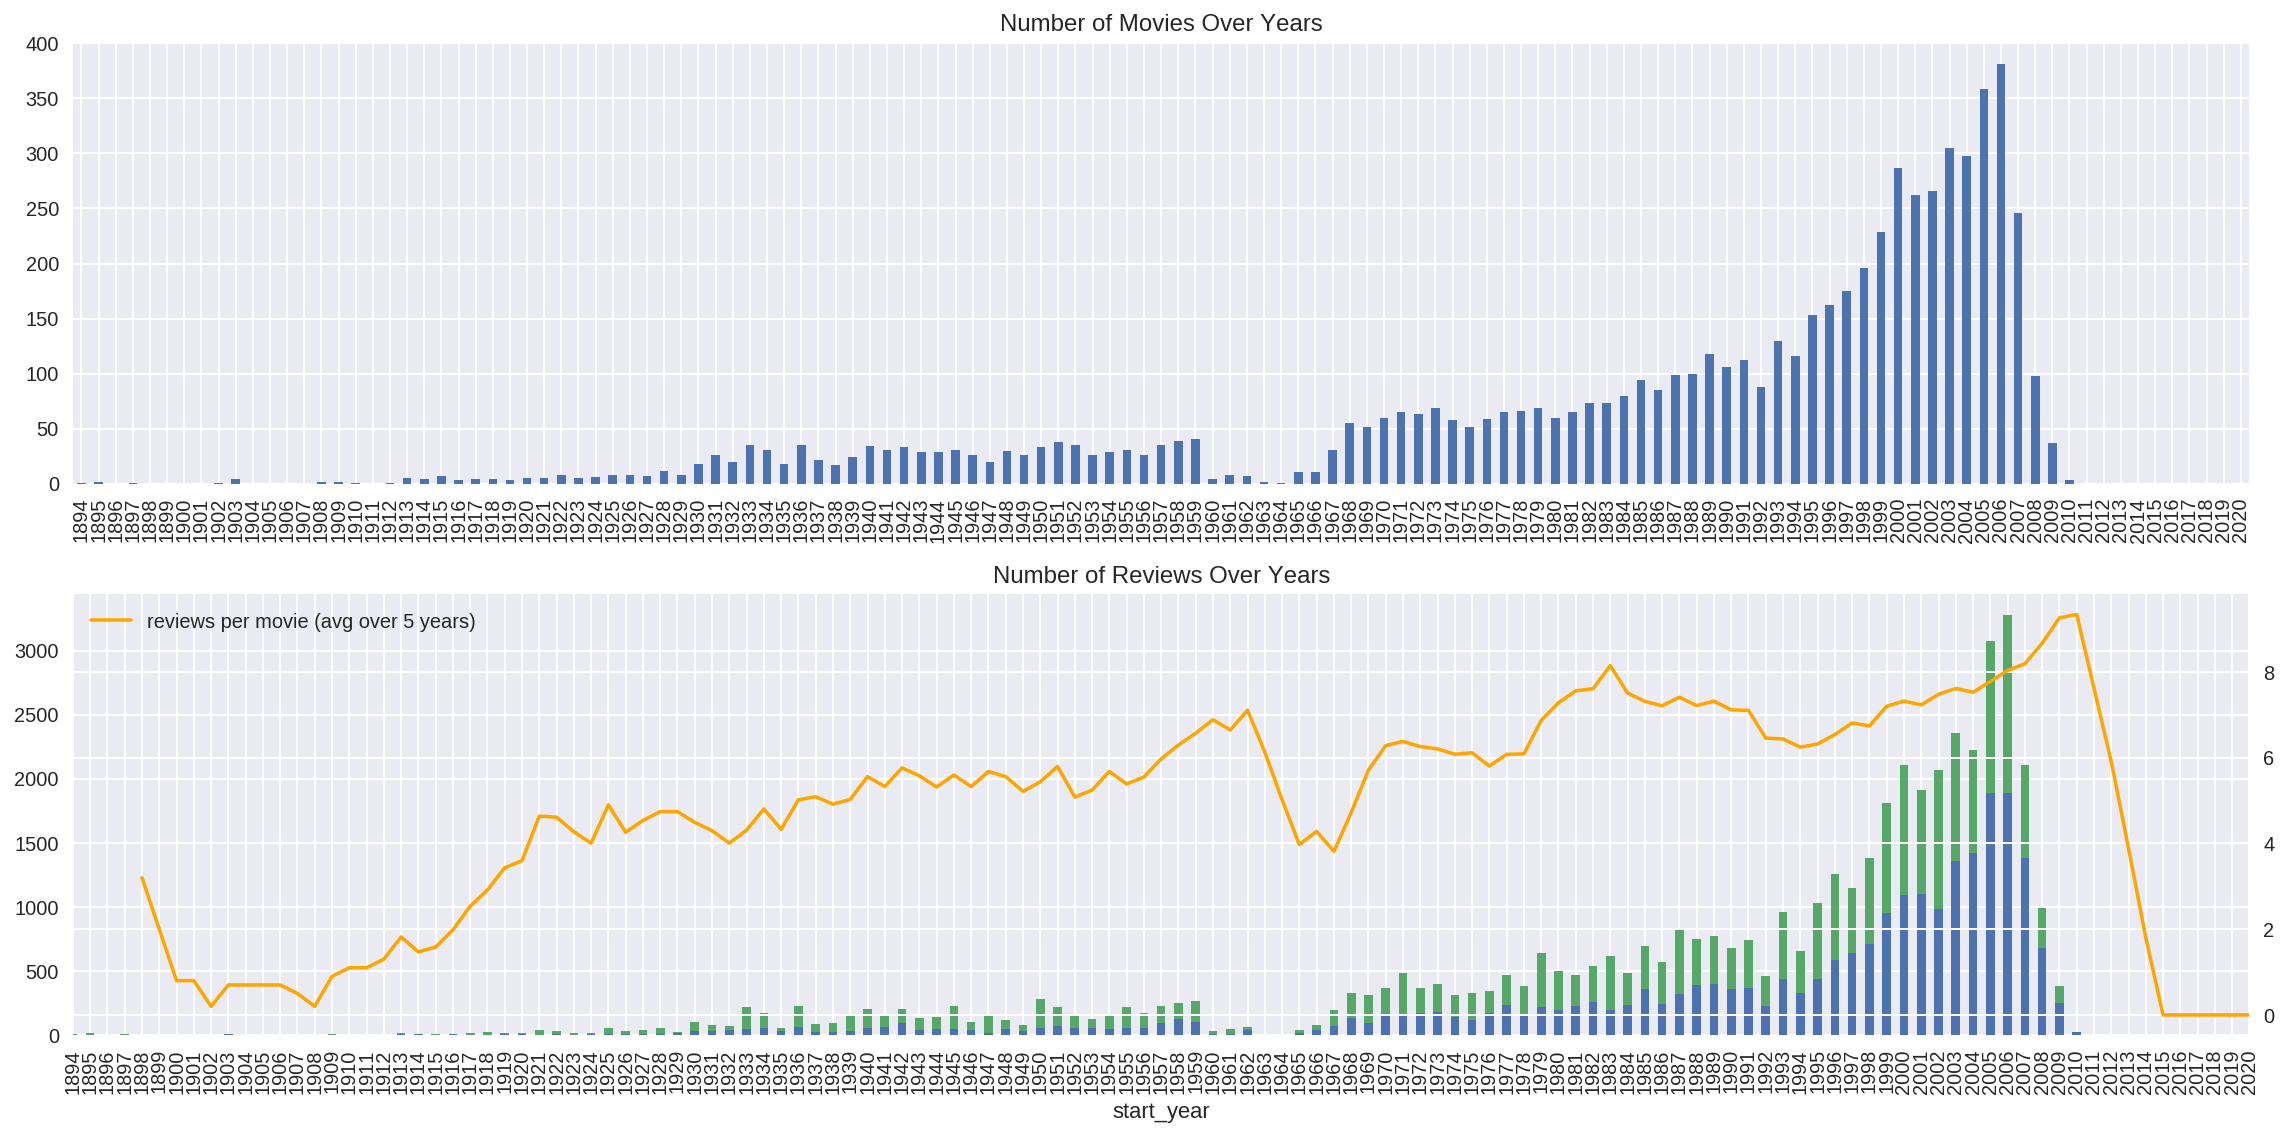

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

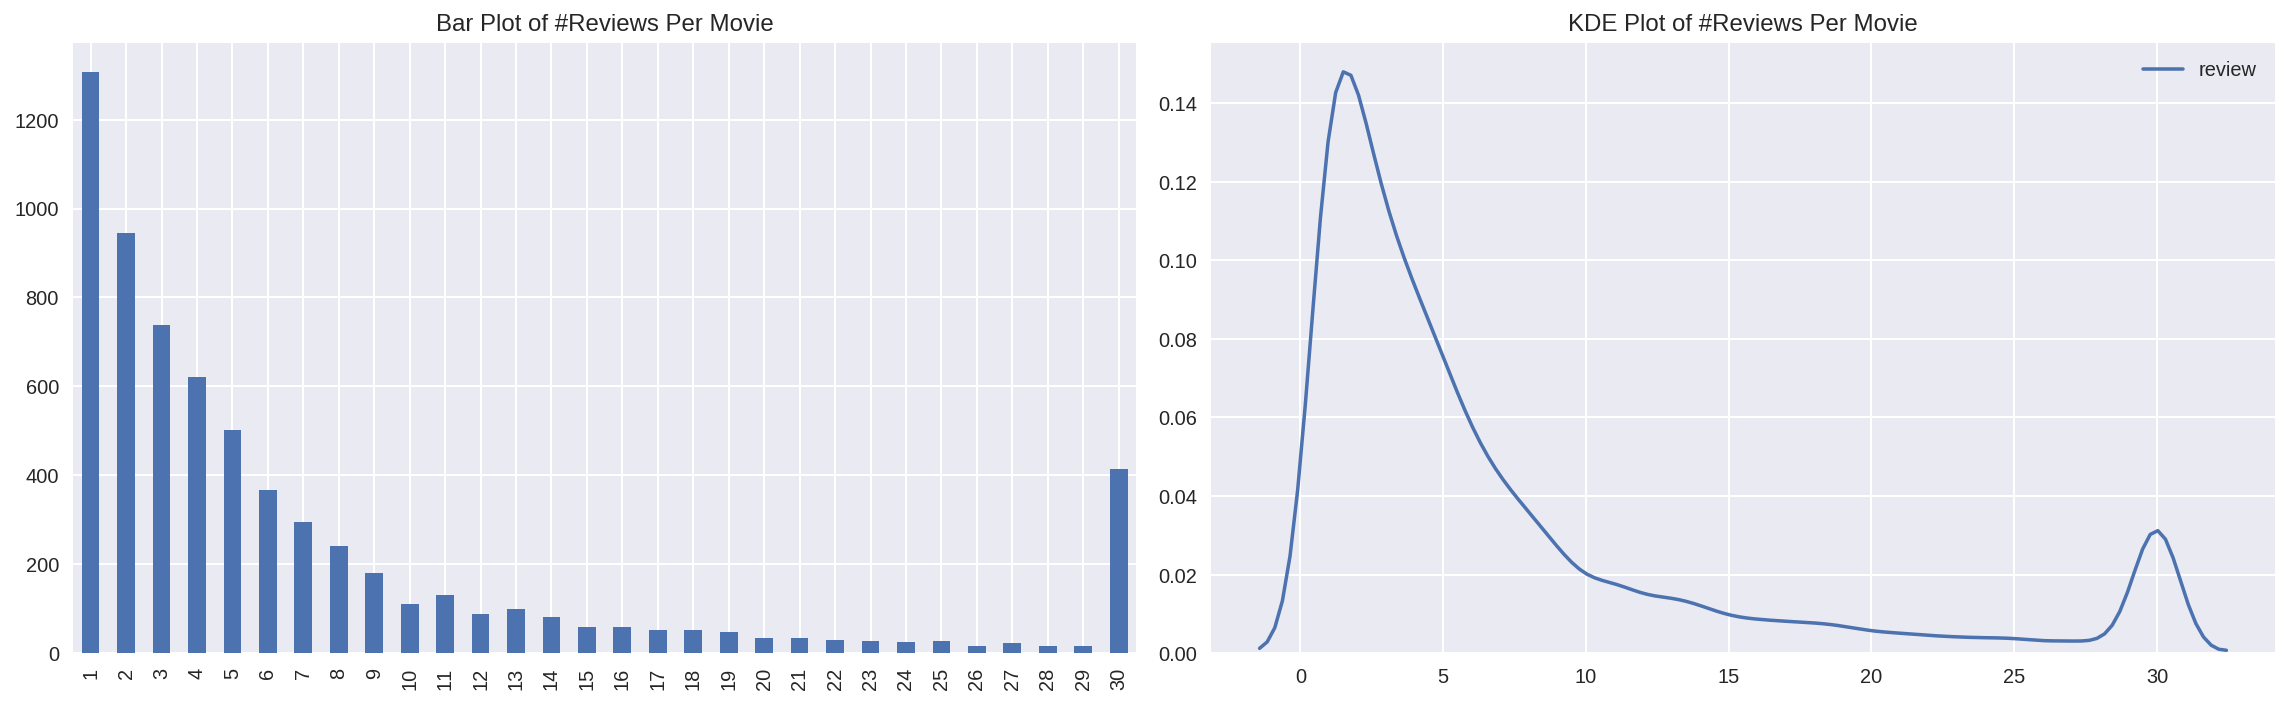

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Number of values for both the classes are very close hence there is no class imbalance

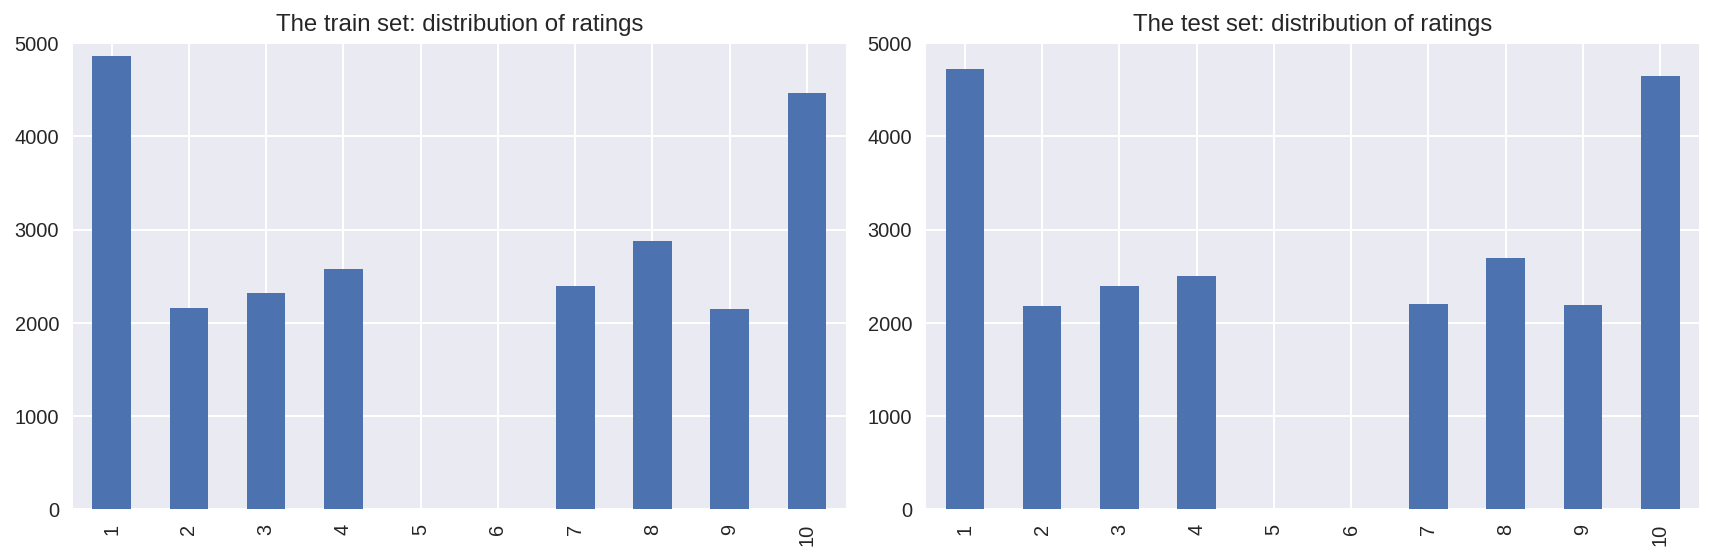

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

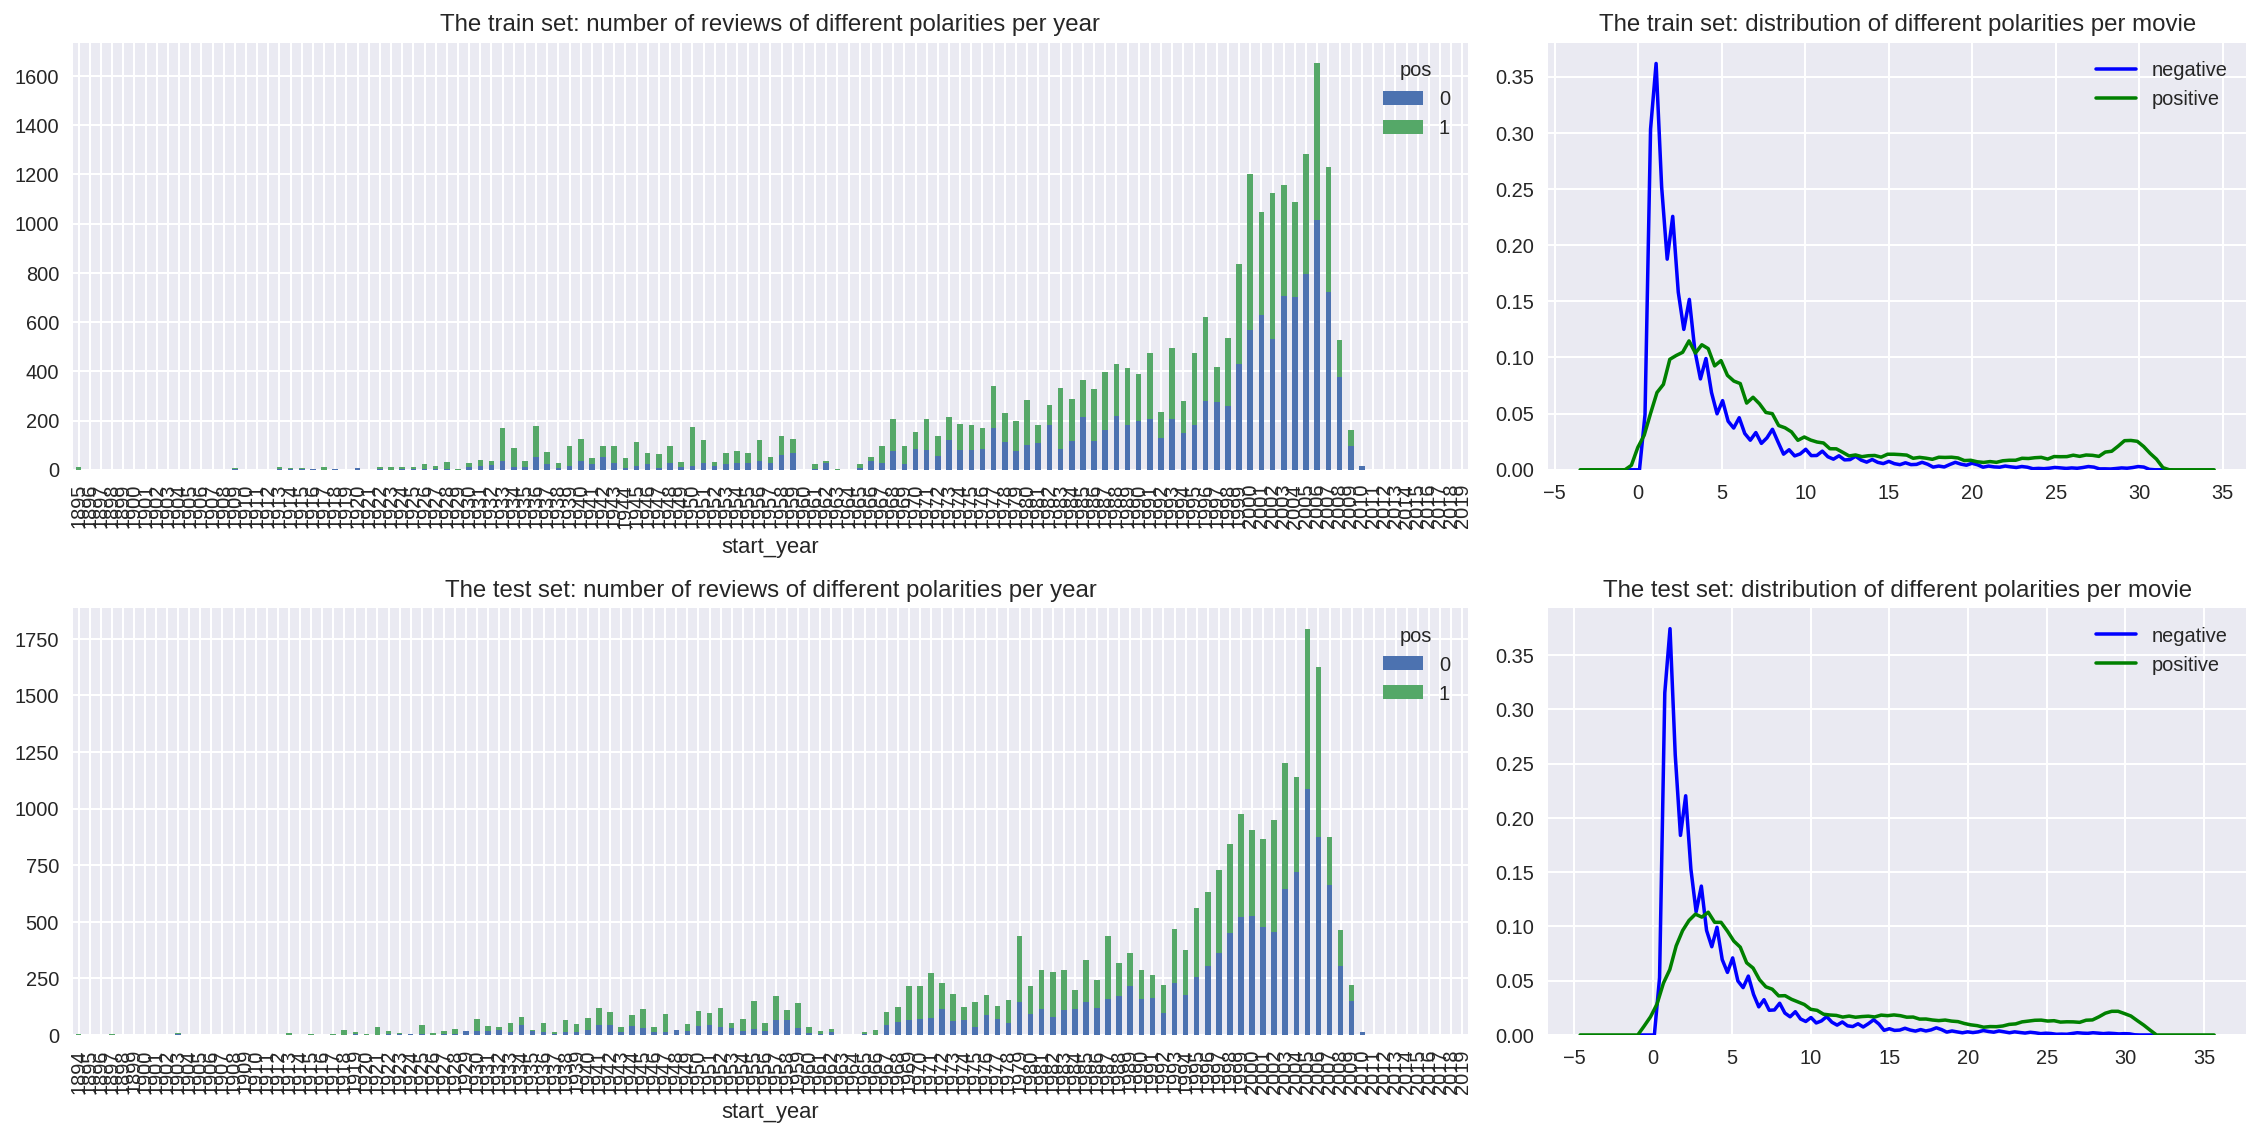

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

# Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

# Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [7]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace("[^a-zA-Z]"," ")

In [9]:
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made   presenti...
2    there is no real story the film seems more lik...
3    um      a serious film about troubled teens in...
4    i m totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

# Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [8]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


# Model 0 - Constant

In [9]:
from sklearn.dummy import DummyClassifier

In [10]:
clf = DummyClassifier()

In [11]:
clf.fit(df_reviews_train['review_norm'],train_target)
clf.predict(df_reviews_train['review_norm'])

array([1, 1, 0, ..., 1, 1, 0])

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


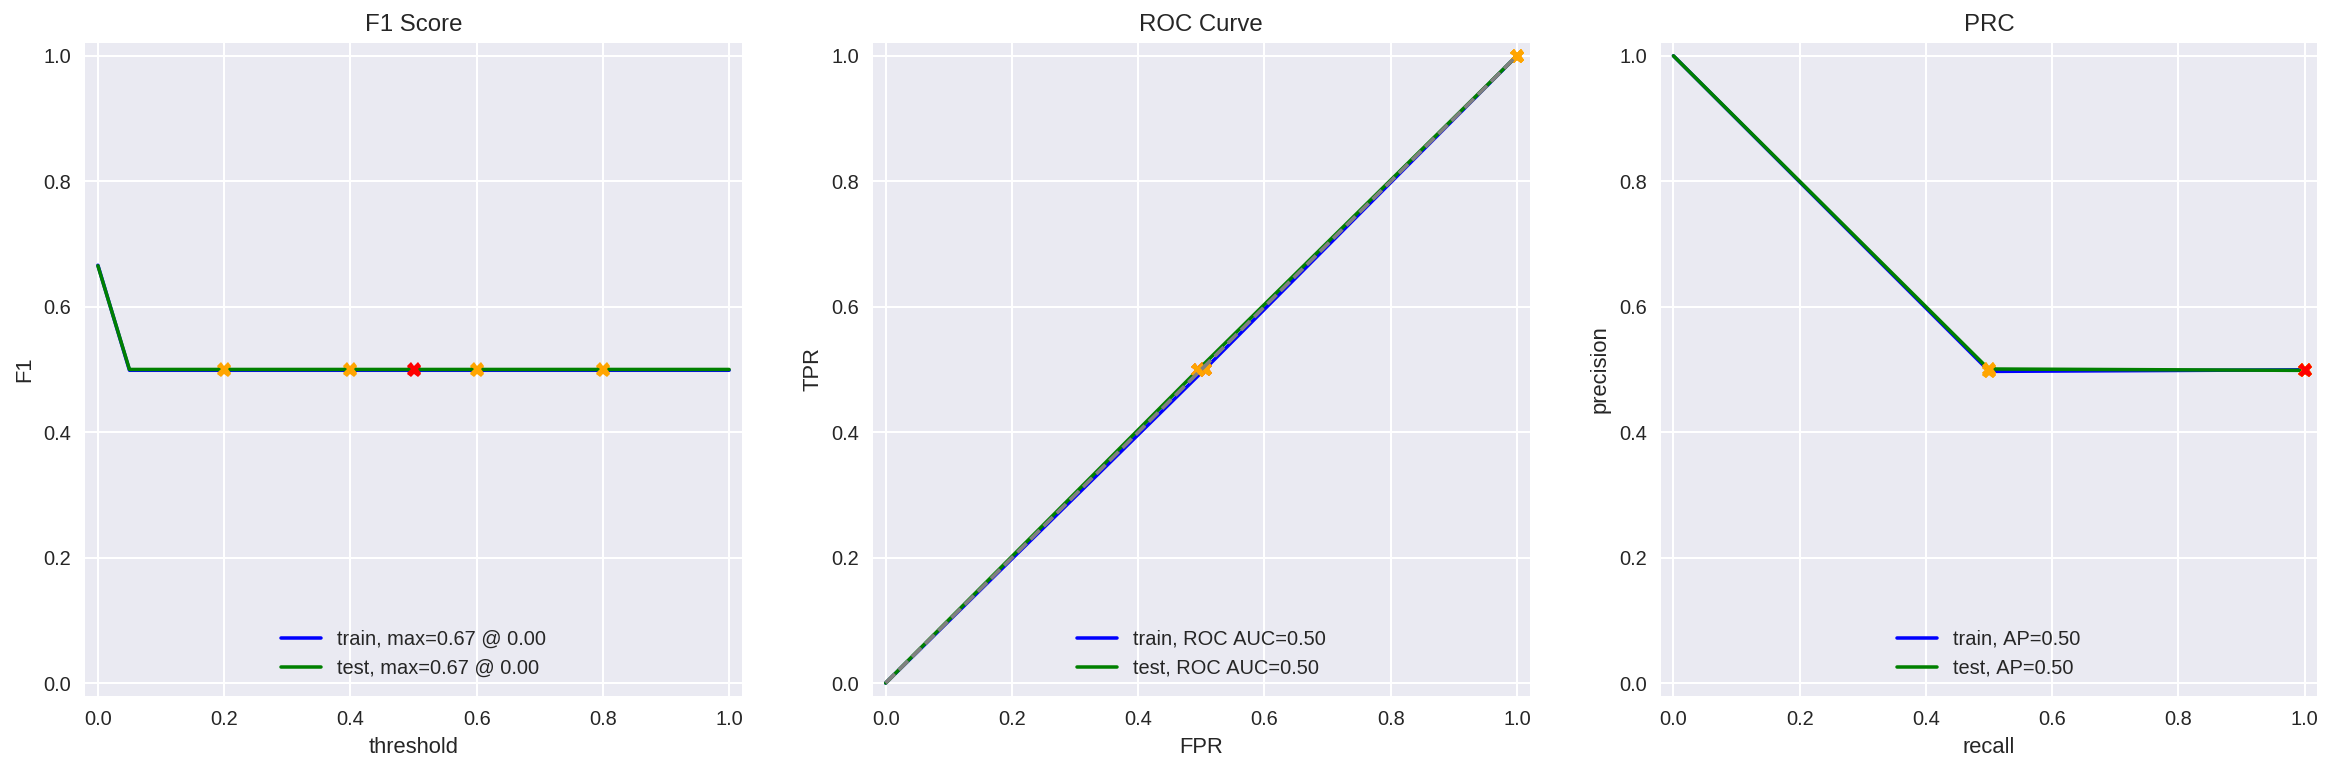

In [14]:
evaluate_model(clf,df_reviews_train['review_norm'],train_target,df_reviews_test['review_norm'],test_target)

# Model 1 - NLTK, TF-IDF and LR

### TF-IDF

In [15]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [16]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [17]:
corpus=df_reviews['review_norm']
lemmatizer  = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [18]:
def lemmatize(text):
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens] 
    return " ".join(lemmas)

corpus=corpus.apply(lemmatize)

In [23]:
tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words,ngram_range=(1,2)) 
#tf_idf= count_tf_idf.fit_transform(corpus[corpus.index in df_reviews_train['review_norm'].index])
#print("The TF-IDF matrix size:", tf_idf.shape)

In [24]:
train_features_1=tf_idf_vectorizer.fit_transform(corpus[df_reviews_train['review_norm'].index])
test_features_1=tf_idf_vectorizer.transform(corpus[df_reviews_test['review_norm'].index])

In [27]:
model_1=LogisticRegression(solver='liblinear',random_state=12345)
model_1.fit(train_features_1,train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='liblinear', tol=0.0001,
                   verbose=0, warm_start=False)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.96  0.88
F1         0.96  0.88
APS        0.99  0.95
ROC AUC    0.99  0.95


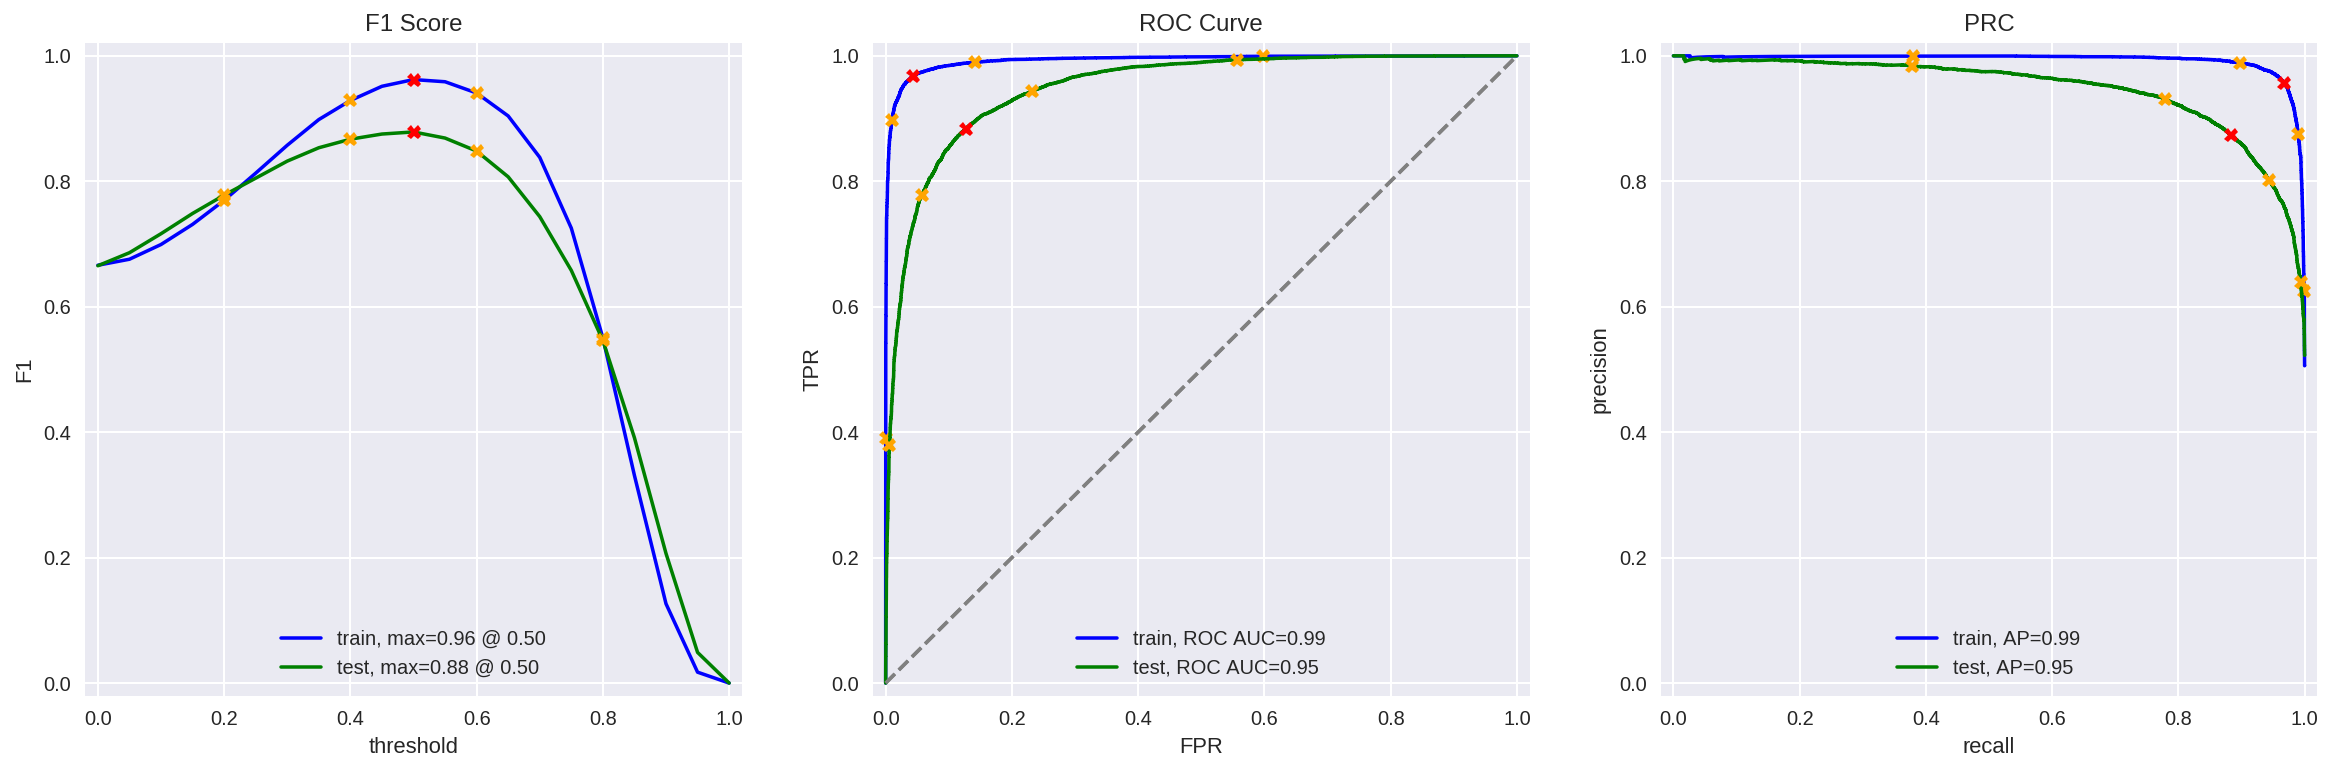

In [28]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

# Model 3 - spaCy, TF-IDF and LR

In [54]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [55]:
corpus=df_reviews['review_norm']

In [56]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [57]:
corpus=corpus.apply(text_preprocessing_3)

In [58]:
tf_idf_vectorizer_3 = TfidfVectorizer(stop_words=stop_words)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


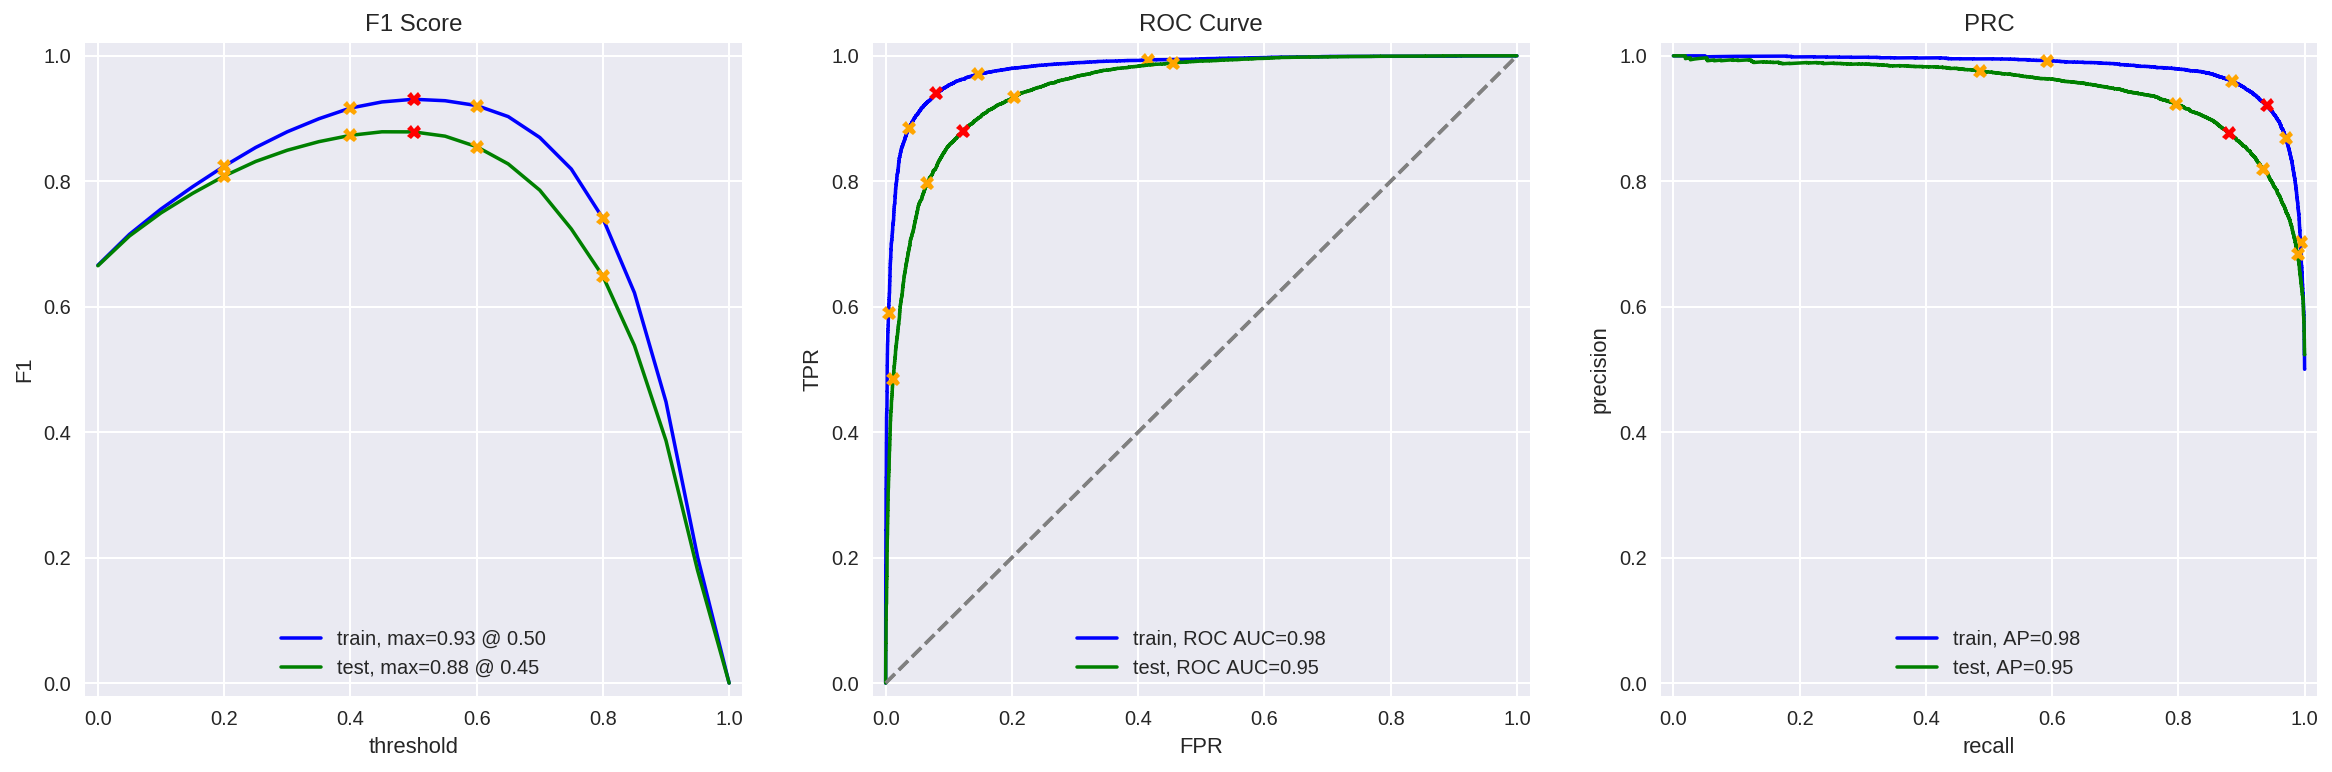

In [59]:
train_features_3=tf_idf_vectorizer_3.fit_transform(corpus[df_reviews_train['review_norm'].index])
test_features_3=tf_idf_vectorizer_3.transform(corpus[df_reviews_test['review_norm'].index])

model_3=LogisticRegression(random_state=12345, class_weight='balanced')
model_3.fit(train_features_3,train_target)

evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

# Model 4 - spaCy, TF-IDF and LGBMClassifier

In [23]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [37]:
train_features_4=train_features_3
test_features_4=test_features_3

In [24]:
tf_idf_vectorizer_4 = TfidfVectorizer(stop_words=stop_words)

In [25]:
train_features_4=tf_idf_vectorizer_4.fit_transform(corpus[df_reviews_train['review_norm'].index])
test_features_4=tf_idf_vectorizer_4.transform(corpus[df_reviews_test['review_norm'].index])

In [26]:
print(train_features_4.shape)
print(test_features_4.shape)

(23796, 60581)
(23535, 60581)


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


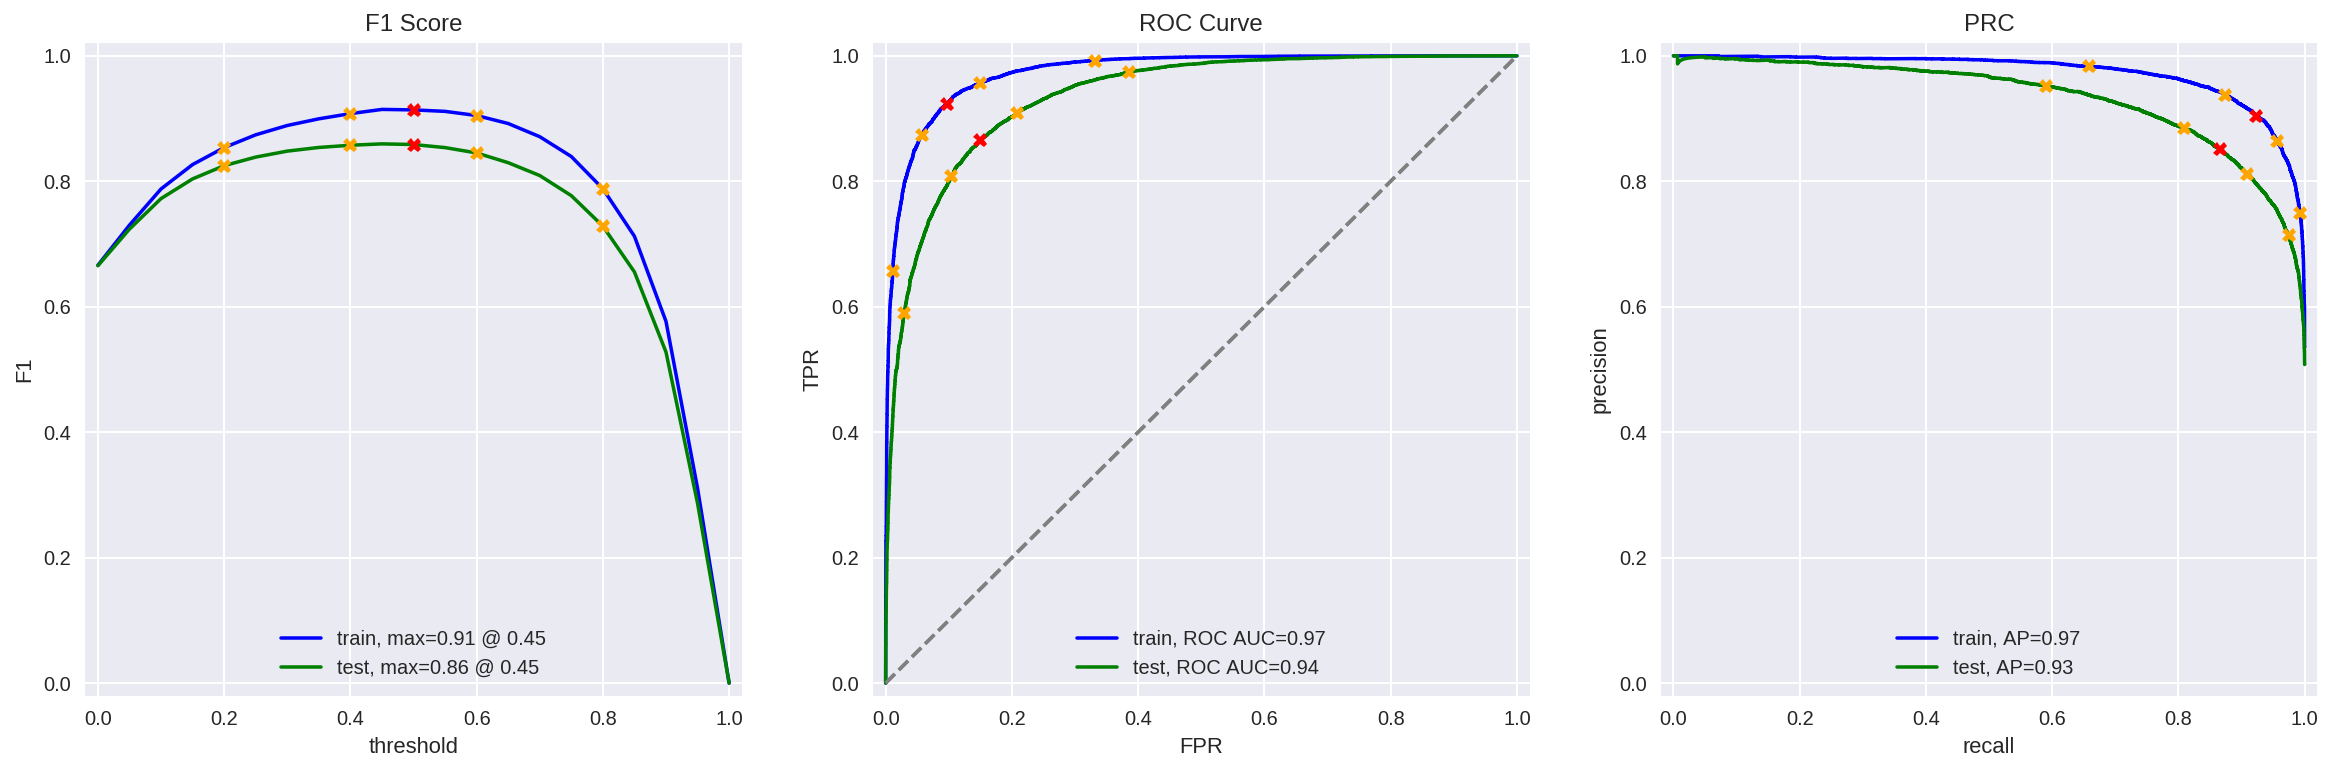

In [37]:
model_4=(LGBMClassifier(learning_rate=0.1,random_state=12345,
                       objective='binary',is_unbalance=False))
model_4.fit(train_features_4,train_target)

evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

#  Model 9 - BERT

In [39]:
import torch
import transformers

In [40]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [41]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=30, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    for input_text in texts:
        ids = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [42]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'][:150], force_device='cpu')

Using the cpu device.


In [43]:
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'][:150], force_device='cpu')

Using the cpu device.


In [44]:
train_target_9=train_target[:150]
test_target_9=test_target[:150]

In [45]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target_9.shape)

(23796,)
(150, 768)
(150,)


In [23]:
print(df_reviews_test['review_norm'].shape)
print(test_features_9.shape)
print(test_target_9.shape)

(23535,)
(150, 768)
(150,)


In [46]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.98  0.80
F1         0.98  0.80
APS        1.00  0.93
ROC AUC    1.00  0.90


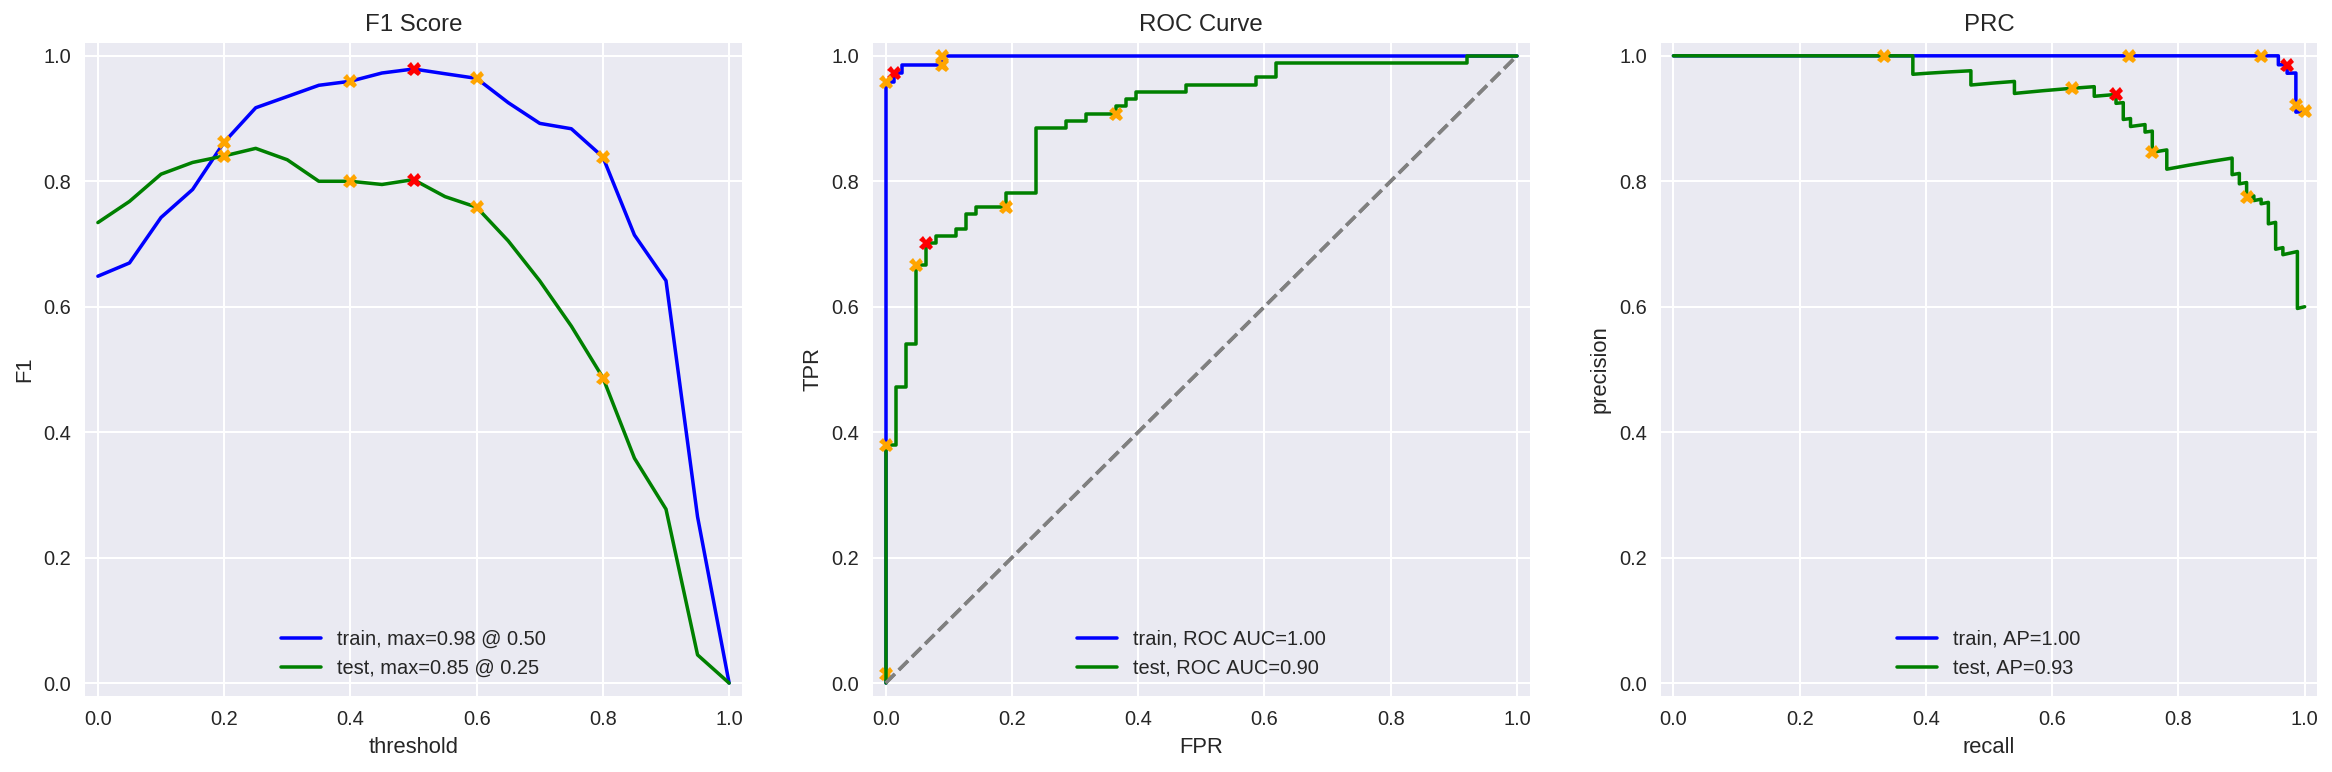

In [52]:
model_9= LogisticRegression(solver='saga',penalty='elasticnet',l1_ratio=0.7,random_state=12345,class_weight='balanced')
model_9.fit(train_features_9,train_target_9)

evaluate_model(model_9,train_features_9,np.array(train_target_9),test_features_9,np.array(test_target_9))

# My Reviews

In [29]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].str.lower().replace("[^a-zA-Z]"," ")
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.","i did not simply like it, not my kind of movie."
1,"Well, I was bored and felt asleep in the middl...","well, i was bored and felt asleep in the middl..."
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good! writ...
5,"The movie had its upsides and downsides, but I...","the movie had its upsides and downsides, but i..."
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy. not a singl...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move & i real...


## Model 1

In [44]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tf_idf_vectorizer.transform(texts.apply(lambda x: lemmatize(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it, not my kind of movie.
0.14:  well, i was bored and felt asleep in the middle of the movie.
0.36:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.24:  i didn't expect the reboot to be so good! writers really cared about the source material
0.56:  the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.04:  what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.88:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


## Model 3

In [60]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tf_idf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.27:  i did not simply like it, not my kind of movie.
0.10:  well, i was bored and felt asleep in the middle of the movie.
0.43:  i was really fascinated with the movie
0.08:  even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.23:  i didn't expect the reboot to be so good! writers really cared about the source material
0.57:  the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.02:  what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.91:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


## Model 4

In [38]:
texts = my_reviews['review_norm']

#tf_idf_vectorizer_4 = tf_idf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tf_idf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.67:  i did not simply like it, not my kind of movie.
0.33:  well, i was bored and felt asleep in the middle of the movie.
0.60:  i was really fascinated with the movie
0.34:  even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.62:  i didn't expect the reboot to be so good! writers really cared about the source material
0.70:  the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.25:  what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.78:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


## Model 9

In [53]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.08:  i did not simply like it, not my kind of movie.
0.02:  well, i was bored and felt asleep in the middle of the movie.
0.08:  i was really fascinated with the movie
0.01:  even the actors looked really old and disinterested, and they got paid to be in the movie. what a so
0.02:  i didn't expect the reboot to be so good! writers really cared about the source material
0.07:  the movie had its upsides and downsides, but i feel like overall it's a decent flick. i could see my
0.00:  what a rotten attempt at a comedy. not a single joke lands, everyone acts annoying and loud, even ki
0.86:  launching on netflix was a brave move & i really appreciate being able to binge on episode after epi


# Conclusions

All models perform better than the baseline model. Model 1 which uses nltk library for tokenization and lemmatization, TfIdf for vectorization and Logistic Regression for model has 0.88 F1 score. Model 3 uses spaCy, Tfidf and Logistic Regression. It also has F1 score of 0.88. Model 4 uses spaCy for tokenization and lemmatization, Tfidf for for vectorization and builds LightGBM. It has an F1 score of 0.86. Model 9 uses BERT for creating embeddings and builds Logistic Regression. It has an F1 score of 0.80. Hence in terms of evaluation metric, F1 score Logistic Regression performs the best.Including ngram_range in TfidfVectorizer deteriorated model performance in all models.

On the reviews created Logistic Regression performs the best. LightGBM predicts over optimistically whereas BERT assigns very low probabilities to all reviews even positive ones. 

Hence Model 3 performs the best.